# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 26th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "sajeevan"
ln1 = "puvikaran"
fn2 = "yanis"
ln2 = "daci"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_puvikaran_sajeevan_and_daci_yanis.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [2]:
%matplotlib inline

In [3]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit

In [4]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [33]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    print(g/n)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [34]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [35]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [36]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [37]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# _A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

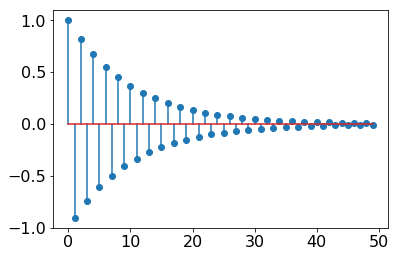

In [38]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [39]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

[-0.92115809  0.29435154  0.1964156  -0.24798805 -0.79088812 -0.32093464
 -1.63181894  1.05713444 -1.4567677  -0.69348286  1.48433754  0.19183391
 -1.32690548 -0.21579262  1.76091827  0.29091213  1.14889283  0.30118575
 -1.05425273 -1.46020691 -0.69274866 -0.1817082   3.54236629  1.89076162
  0.9934287   0.74865517 -0.48961441  1.74139524 -0.03632951  0.84536405
  0.10387043  0.10041493 -0.74145658 -0.98773497  1.32461909  1.82867998
  1.66236357 -0.34652768 -0.45709883 -0.69432304  0.26049073  1.29555509
 -1.71007509 -0.53918487  0.07080986  1.96514965  0.63055237  0.46564674
  0.16749295 -0.23367863]


1.4199496458122507e-06

In [40]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

2.3468417679199713e-07

### Choice of the model

In [41]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [42]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06305730136079472


### Get a very precise minimum to compute distances to minimum

In [43]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad(x_min, A, b, lbda)))

[-0.5488901  -0.39083812 -0.43847616 -0.31838751 -0.36636463 -0.26487996
 -0.30126548 -0.21167053 -0.23328368 -0.16189871 -0.18727011 -0.13646733
 -0.15004418 -0.10681468 -0.10974038 -0.07978426 -0.08710302 -0.05663666
 -0.05881656 -0.03834143 -0.040113   -0.03089913 -0.04431156 -0.03034662
 -0.02581638 -0.01692565 -0.02005961 -0.01854625 -0.02393745 -0.01169382
 -0.01152405 -0.00871712  0.00284428  0.00953258  0.01295905  0.01044795
  0.00275159 -0.00130004  0.01135691  0.00986317  0.00796945  0.01105193
  0.0131306   0.02475266  0.03319845  0.03839223  0.03027615  0.02949313
  0.02657935  0.01202385]
[ 1.68104431  1.96684582  2.03691983  2.21303004  2.19248004  2.27889901
  2.19268026  2.22047311  2.12166607  2.08181978  1.97622411  1.92774125
  1.79954207  1.73855176  1.61412469  1.51724795  1.40935132  1.32025866
  1.21329706  1.11558135  1.02953839  0.97927305  0.89477185  0.80586211
  0.74473331  0.68468122  0.62186819  0.55350763  0.50561343  0.45097371
  0.39094424  0.37128966 

[ 1.97913167e-04  1.92982994e-04  2.51303593e-04  1.22420754e-04
 -8.47780846e-05  1.59753747e-04  7.81312228e-05  6.19561213e-05
 -5.75729797e-05  1.62803663e-04  1.50164336e-04  1.70938919e-04
  4.23068538e-05 -7.20286476e-05 -1.61875442e-04 -6.94547123e-05
 -6.24450350e-05  1.22614307e-04 -9.59889731e-05 -5.34008114e-05
 -2.96415834e-04 -2.92817688e-04 -3.80324046e-04 -3.55431957e-04
 -3.20353797e-04 -1.61797050e-04 -2.51890360e-04 -1.90029178e-04
 -2.22353978e-04 -2.50255188e-04 -1.53254937e-04 -1.92382833e-04
 -1.18975022e-04 -4.82542929e-05  5.08308090e-05  1.57576727e-04
  1.79625897e-04  2.94251505e-04  2.79856832e-04  3.27116718e-04
  1.91599915e-04  2.30958016e-04  6.89937344e-05  1.57120935e-04
  1.05721024e-04  9.88892322e-05  1.96289570e-04  2.27106824e-04
  2.57281095e-04  2.54371072e-04]
[ 4.48797236e-05  1.21947084e-04  1.68206348e-04  2.26499247e-05
 -4.98455665e-05  1.84805567e-04  9.50399001e-05  3.95051058e-05
 -3.26480190e-05  1.52609026e-04  1.26630490e-04  9.8213

[ 2.22637287e-06  2.36879392e-06  2.56268105e-06  2.84079337e-06
  2.75005673e-06  1.58770155e-06  2.24114006e-06  1.19678647e-06
  2.45903744e-07 -1.01869220e-07  6.17650510e-07  1.76366774e-07
 -7.68427414e-07 -8.53578182e-07 -1.07876351e-06 -7.77495037e-07
 -6.94969704e-07 -7.16021426e-07 -1.06830753e-06 -1.24854722e-06
 -1.86094471e-06 -2.28316062e-06 -3.12011204e-06 -2.39672486e-06
 -1.92560419e-06 -8.36844030e-07  1.08457322e-07 -3.61872796e-08
 -2.33228794e-07 -1.99813966e-07  4.35270732e-08  3.35668215e-07
  1.01286632e-06  1.60898825e-06  1.95492934e-06  1.99060983e-06
  1.93714053e-06  1.98936840e-06  1.88781683e-06  2.78553809e-06
  2.61998054e-06  3.03702904e-06  3.00579344e-06  3.06496429e-06
  2.57699911e-06  2.65300637e-06  2.71754171e-06  2.89970618e-06
  2.81666103e-06  2.79236277e-06]
[ 6.88509113e-07  7.90514463e-07  8.72852171e-07  1.04881187e-06
  9.46332051e-07 -1.29744316e-08  8.24736989e-07 -6.06621452e-08
 -6.99678840e-07 -7.17840520e-07  2.58305317e-07  7.2505

[-2.71687041e-09 -5.70915913e-09 -2.89844605e-09 -7.41643981e-09
 -6.15386721e-09 -1.08105449e-08 -9.93846177e-09 -1.47206616e-08
 -1.10093614e-08 -1.42499684e-08 -8.58985803e-09 -3.08523669e-09
 -4.07996830e-09 -7.61095920e-09 -9.46504678e-09 -1.13479082e-08
 -1.28810940e-08 -1.15096445e-08 -8.66677904e-09 -4.90977489e-09
 -1.13699871e-08 -1.21350346e-08 -1.38204734e-08 -1.03599453e-08
 -8.32282213e-09 -6.64662285e-09 -9.75318961e-09 -1.18399577e-08
 -1.21511775e-08 -1.42912557e-08 -1.49405039e-08 -1.85655087e-08
 -1.89823650e-08 -1.94405692e-08 -1.61258572e-08 -1.36207131e-08
 -1.49312059e-08 -1.14500316e-08 -1.16832036e-08 -7.94154937e-09
 -7.35261448e-09 -4.41181355e-10 -2.01166624e-09 -1.53286386e-09
 -6.19504024e-09 -8.12449746e-09 -1.01374351e-08 -9.24718333e-09
 -7.80132244e-09 -7.71227390e-09]
[ 6.02693483e-09  2.44526613e-09  5.78482532e-09  2.46211917e-09
  1.86402825e-09 -2.96310685e-10  1.33732183e-09 -7.79801446e-10
  1.12159173e-09  3.92075882e-10  6.95304060e-09  1.2123

<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [44]:
import numba
print(numba.__version__)

0.40.0


In [45]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [46]:
# Number of iterations
n_iter = 50

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [52]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        
        ### TODO
        x = x - step * grad(x, args[0], args[1], args[2]) 
        
        if i == 0 :
            """
            print(step)
            print(grad(x, args[0], args[1], args[2]))
            print(x)
            """
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    #print(x)
    return x, x_list

In [53]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

[-0.5488901  -0.39083812 -0.43847616 -0.31838751 -0.36636463 -0.26487996
 -0.30126548 -0.21167053 -0.23328368 -0.16189871 -0.18727011 -0.13646733
 -0.15004418 -0.10681468 -0.10974038 -0.07978426 -0.08710302 -0.05663666
 -0.05881656 -0.03834143 -0.040113   -0.03089913 -0.04431156 -0.03034662
 -0.02581638 -0.01692565 -0.02005961 -0.01854625 -0.02393745 -0.01169382
 -0.01152405 -0.00871712  0.00284428  0.00953258  0.01295905  0.01044795
  0.00275159 -0.00130004  0.01135691  0.00986317  0.00796945  0.01105193
  0.0131306   0.02475266  0.03319845  0.03839223  0.03027615  0.02949313
  0.02657935  0.01202385]
[-3.88266497e-01 -2.21012634e-01 -2.60171796e-01 -1.36047884e-01
 -1.82049407e-01 -8.16499308e-02 -1.21624973e-01 -3.64816612e-02
 -6.36551442e-02 -2.82228142e-04 -3.14322330e-02  1.22189384e-02
 -9.61423611e-03  2.61082500e-02  1.44307274e-02  3.52509942e-02
  2.06875463e-02  4.25419898e-02  3.28146018e-02  4.47763663e-02
  3.69346734e-02  4.18642207e-02  2.33312177e-02  2.98860338e-02


### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [21]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        ### TODO
        x_new = y - step * grad(y, args[0], args[1], args[2])
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        y = x_new + ((t - 1) / t_new) * (x_new - x)
        
        x, t = x_new, t_new
        ### END TODO
    return x, x_list

In [22]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s nonlinear conjuguate gradient solver. First, define a function to run scipy algorithms and return the list of iterates.

In [23]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [24]:
# Nonlinear Conjugate gradient algorithm
from scipy.optimize import fmin_cg

x_init = np.zeros(d)

monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)

         Current function value: 0.536285
         Iterations: 50
         Function evaluations: 82
         Gradient evaluations: 82


### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [25]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [26]:
def plot_epochs(monitors, solvers, title_sup=""):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss %s" % title_sup)
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum %s" % title_sup)
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers, title_sup=""):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss %s" % title_sup)
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

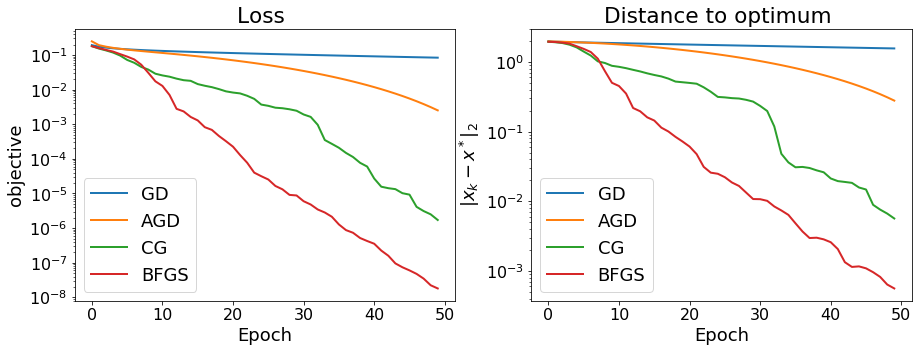

In [27]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs]

solvers = ["GD", "AGD", "CG", "BFGS"]

plot_epochs(monitors, solvers)

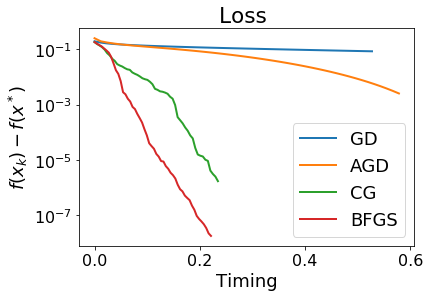

In [28]:
plot_time(monitors, solvers)

- We find the same results in the graphs below in terms of distance to optimum (precision).

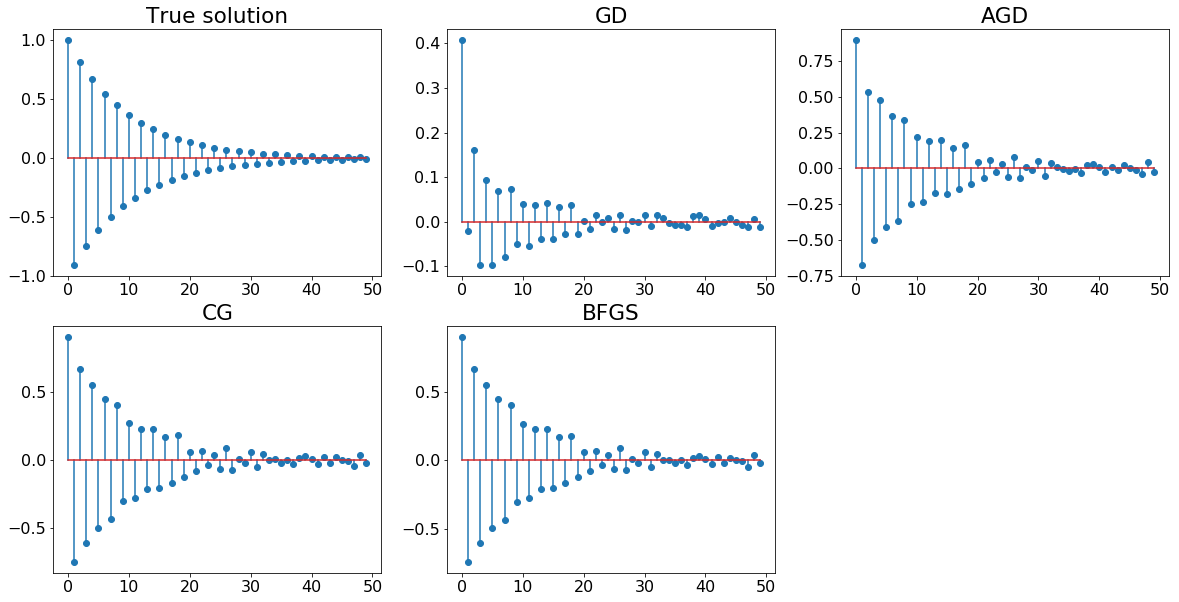

In [29]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
plt.stem(x_model_truth)
plt.title("True solution")

indice = range(1, 5)
method = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs]
method_name = ["GD", "AGD", "CG", "BFGS"]
for i, method, name in zip(indice, method, method_name):
    plt.subplot(2, 3, i + 1)
    plt.stem(method.x_list[-1]);
    plt.title(name)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here

    - Observation with correlation corr = <b>0,9</b> and step $ \lambda = \boldsymbol{\frac{1}{\sqrt{n}}} $: <br>
AGD is more accurate and faster than GD. This result is not surprising because AGD is an accelerated GD.
    
    - Observation depending on the correlation:
        - Linear regression:
        For small correlation, GD converges faster and more accurately than AGD.
        For big correlation, AGD converges faster than GD.
        
        - Logistic regression:
        AGD converges faster than GD for both cases.
        
    
    
    
    
In each case, BFGS and CG are faster than GD or AGD. After some iterations, BFGS has the best performance in terms of convergence.

- What do you observe about AGD? is it suprising ?

    - AGD is not monotonous on the objective and distance to optimum graphs in the linear regression case for small correlation. That is surprising as AGD belongs to the Gradient Descent Methods. For Logistic regression, AGD is linear.
    
    - GD converges faster and more accurately than AGD when small correlation and with linear regression. It should be the contrary as AGD is an accelerated version of GD. We can explain that fact by the complexity of the AGD algorithm. In our problem, we have good conditions. Indeed, we use the linear regression model and the features are independent due to the small correlation. So we don't need a complex model for this case and a simpler model like GD will be more effective.

<a id='stoc'></a> 
## 4. Stochastic methods

In [30]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [31]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x = x - (step / (np.sqrt(idx + 1))) * grad_i(i, x, args[0], args[1], args[2])
        ### END TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [32]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter * n, step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [33]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]

        ### TODO
        averaged_gradient =  averaged_gradient - 1 / store_every * gradient_memory[i,:]
        gradient_memory[i,:] = grad_i(i, x, args[0], args[1], args[2])
        averaged_gradient =  averaged_gradient + 1 / store_every * gradient_memory[i,:]
            
        x = x - step * averaged_gradient
        ### END OF TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [34]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter * n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [35]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=1, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter):
        ### TODO
        x_old = x.copy()
        mu = grad(x_old, args[0], args[1], args[2])
        for k in range(n):
            i = iis[k]
            x = x - step * (grad_i(i, x, args[0], args[1], args[2]) - grad_i(i, x_old, args[0], args[1], args[2]) + mu)
        ### END TODO        
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [36]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter, step, args=(A, b, lbda))

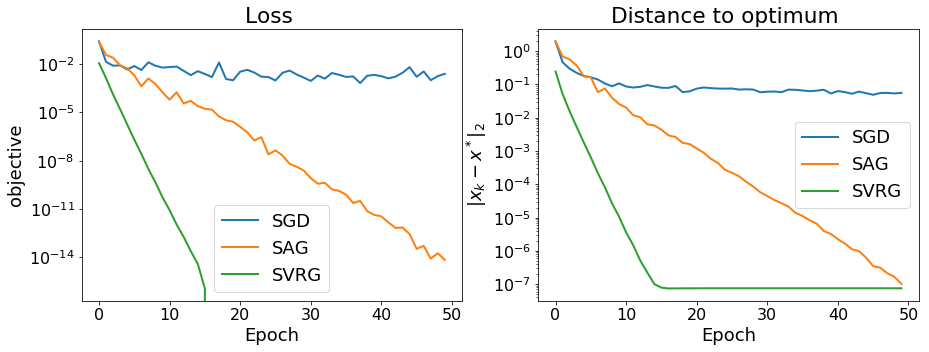

In [37]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

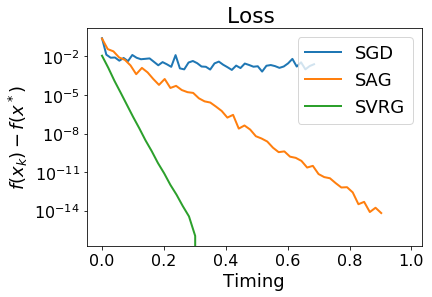

In [38]:
plot_time(monitors, solvers)

<a id='comp'></a> 
## 5. Numerical comparison

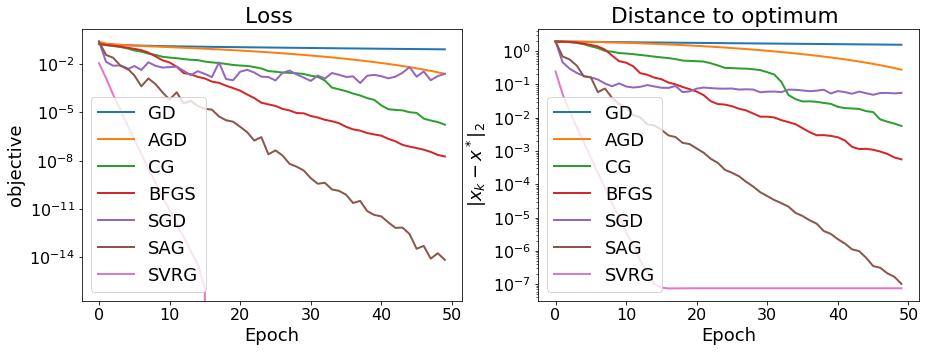

In [39]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

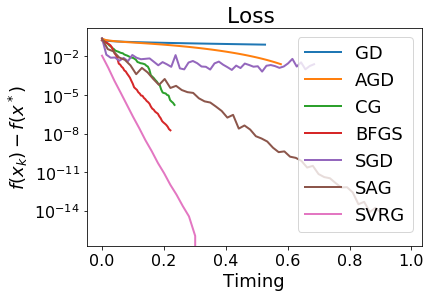

In [40]:
plot_time(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

*COMMENT*:<br>

The graphs are plotted per **epoch** in order to compare Batch methods with Stochastic methods. Indeed in deterministic model, gradients of all functions f_i are computed. Therefore, doing one iteration in the **for** loop is equivalent to an epoch and that is the reason why we compute n_iters (=50) epochs which is equivalent to 500,000 gradients computation.

On the other hand, for SGD and SAG, there is only a single gradient per iteration (in the **for** loop). Therefore, we will not calculate the same number of gradient than for Batch methods. For purposes of comparability, we will execute the loop until $ 50 \times 10,000 = 500,000 $ iterations or gradients computation (n_iters $\times$ n).

Finally, for SVRG, the algorithm takes in account the computation of 10,000 gradients (Equivalent to 1 epoch) per iteration (in the **for** loop). Therefore, we just have to do 50 iterations (50 epochs) to compute the same number of gradients.

The different methods are now comparable.

*QUESTIONS*:

- Compare and comment your results

<b>Answer:</b><br>
For our study, we used a step $ \lambda = \boldsymbol{\frac{1}{\sqrt{n}}} $ and a correlation corr = <b>0,9</b>. We obtained the following results: 

In loss and distance to optimum computation, the results are quite similar:

\- <b>GD-AGD: </b> GD and AGD method are not accurate at all even if they do not take too much time to do calculations.
        
\- <b>SGD: </b> As we know, SGD is really fast and accurate at the very beginning but gives as bad results as the 2 first deterministic methods (GD and AGD) because this method turns around the solution without converging. This speed of convergence can be explained by a better exploitation of the information. 
Here in this example, we use 0.9 as the correlation value (high correlation) and so, it leads to a lot of redundancy. For SGD, this is not an issue as we compute only a single gradient contrary to GD, which is inneficient as we have to compute all the gradients. Moreover, SGD is very cheap in terms of per-iteration cost. Finally, to maintain adequate results after the beginning, we can reduce the stepsizes (shrinking stepsize) of SGD.  
        
\- <b>CG-BFGS: </b> The other deterministic methods (CG and BFGS) are really fast and give good performances. They are quicker than SGD or SAG but are not accurate comparing to the SAG model.      
        
\- <b>SAG-SVRG: </b> The two last stochastic algorithms (SAG and SVRG) are more accurate than the other methods even if SAG is taking too much time to converge. Indeed, the SAG algorithm keeps in memory gradients of all functions. It is the goal of the variable "gradient_memory" in the SAG function. Consequently, its execution requires extra memory and the computation of the average gradient for each iteration. Thus, SAG will need more time to compute the solution. It takes more than 0.8 to reach a loss of $10^{-14}$. 

The good results of the stochastic algorithms are not surprising. By definition, there are two ways to reduce the variance and to improve SGD:
     
     - The SAG (Stochastic Averaged Gradient) algorithm does an average of iterations to improve convergence. In this way, it reduces the noise.

     - The SVRG (Stochastic Variance Reduced Gradient) algorithm does an aggregation of past gradient information to reduce variance.

The variance when we use SAG algorithm is reduced but the gradient estimates and updates become biased ($ \mathbb{E}[G_t] \ne \nabla f(x_t)$). SVRG algorithm is by far the best algorithm in terms of accuracy and speed because it solves the problem of high variance. Moreover, it uses unbiased updates. Finally, the estimation of the gradient is more stable. Indeed, the graph of the SVRG method is less fluctuating that the SAG and SGD ones.


<br>        
- Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.

In [41]:
def plot_all():
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)
    
    max_squared_sum = np.max(np.sum(A ** 2, axis=1))
    steps = [1. / lipschitz_constant(A, b, lbda), 1. / lipschitz_constant(A, b, lbda), 
             "", "", 1e-1, 1.0 / (max_squared_sum + lbda), 1.0 / (max_squared_sum + lbda)]
    monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
                monitor_sgd, monitor_sag, monitor_svrg]
    solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]
    methods = [gd, agd, scipy_runner(fmin_cg), scipy_runner(fmin_l_bfgs_b), sgd, sag, svrg]
    
    for i in range(len(monitors)):
        x_init = np.zeros(d)
        monitors[i] = monitor(methods[i], loss, x_min, (A, b ,lbda))

        if i in [0, 1]:
            monitors[i].run(x_init, grad, n_iter, steps[i], args=(A, b, lbda))
        elif i in [2, 3]:
            if i == 2:
                monitors[i].run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)
            else:
                monitors[i].run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)
        elif i in [4, 5]:
            monitors[i].run(x_init, iis, grad_i, n_iter * n, steps[i], args=(A, b, lbda))
        else:
            monitors[i].run(x_init, iis, grad, grad_i, n_iter, steps[i], args=(A, b, lbda))
    return monitors, solvers

### Effects of $\lambda $ with linear regression

         Current function value: 0.503165
         Iterations: 50
         Function evaluations: 80
         Gradient evaluations: 80
         Current function value: 0.525935
         Iterations: 50
         Function evaluations: 83
         Gradient evaluations: 83


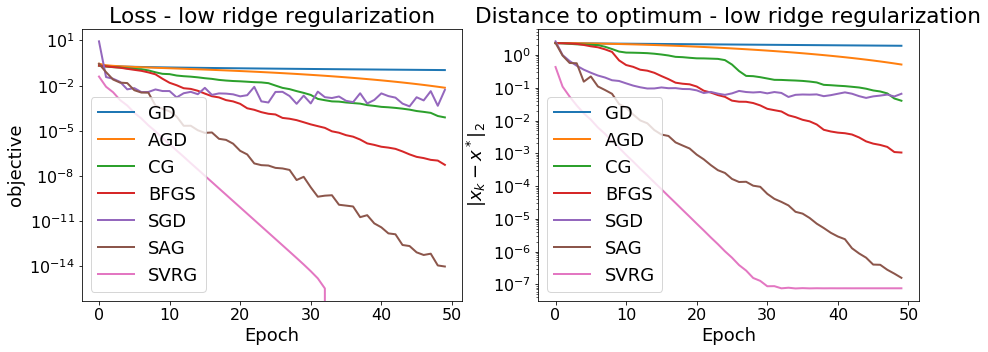

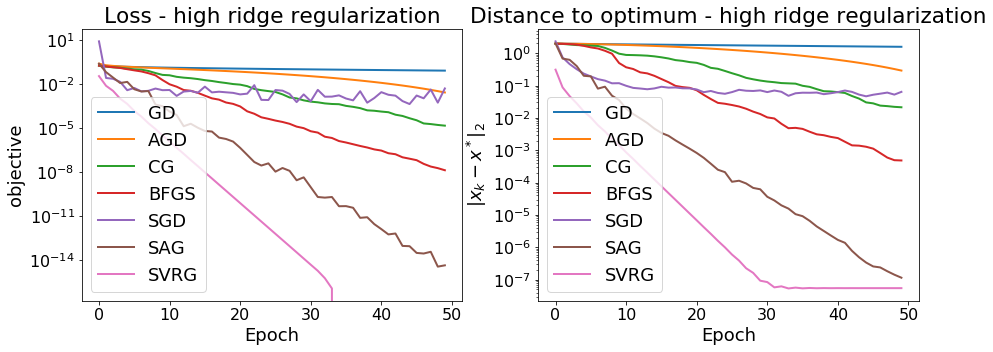

In [42]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
title = ["low", "high"]
i = 0

for lbda in [1. / n, 1. / n ** (0.5)]:
    monitors, solvers = plot_all()
    plot_epochs(monitors, solvers, title_sup="- %s ridge regularization" % title[i])
    i += 1

         Current function value: 0.503165
         Iterations: 50
         Function evaluations: 80
         Gradient evaluations: 80
         Current function value: 0.525935
         Iterations: 50
         Function evaluations: 83
         Gradient evaluations: 83


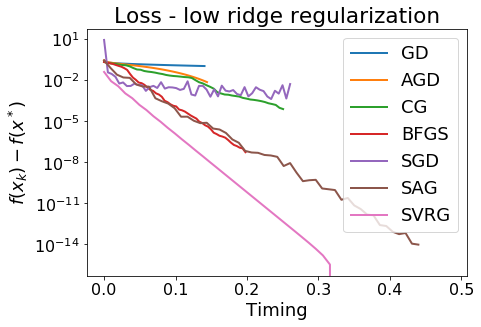

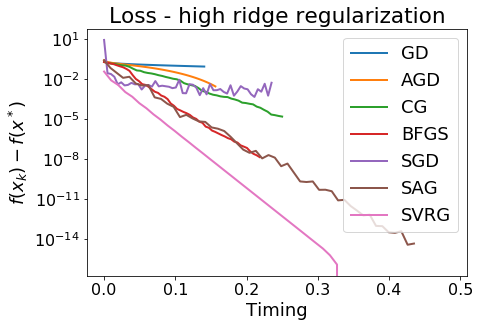

In [43]:
i = 0

for lbda in [1. / n, 1. / n ** (0.5)]:
    monitors, solvers = plot_all()
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, i+1)
    plot_time(monitors, solvers, title_sup="- %s ridge regularization" % title[i])
    i += 1

For the linear regression, we don't observe significant changes when changing the penalization.

### Effects of $\lambda $ with logistic regression

         Current function value: 0.570308
         Iterations: 50
         Function evaluations: 75
         Gradient evaluations: 75
         Current function value: 0.604977
         Iterations: 50
         Function evaluations: 70
         Gradient evaluations: 70


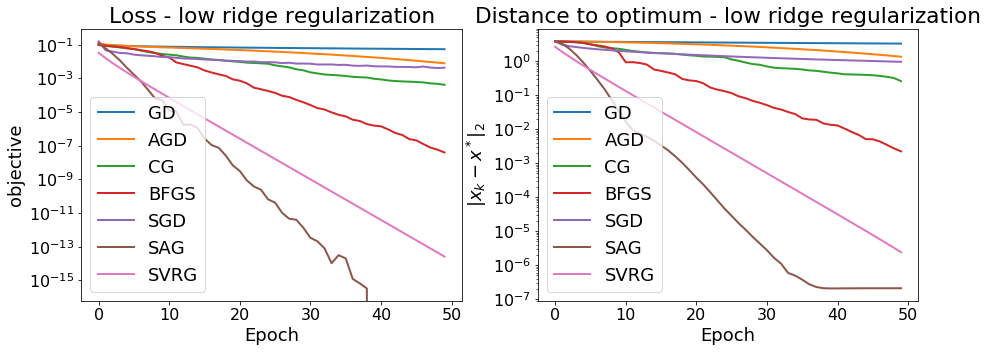

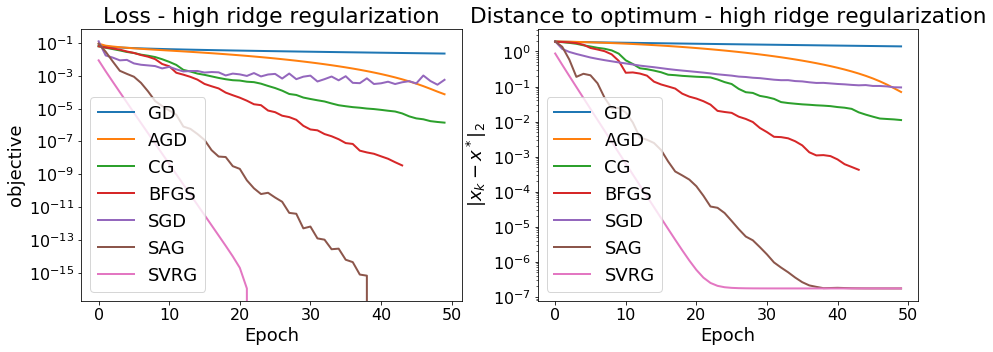

In [44]:
A, b = simu_logreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_logreg
grad = grad_logreg
grad_i = grad_i_logreg
lipschitz_constant = lipschitz_logreg
lbda = 1. / n
title = ["low", "high"]
i = 0

for lbda in [1. / n, 1. / n ** (0.5)]:
    monitors, solvers = plot_all()
    plot_epochs(monitors, solvers, title_sup="- %s ridge regularization" % title[i])
    i += 1

         Current function value: 0.570308
         Iterations: 50
         Function evaluations: 75
         Gradient evaluations: 75
         Current function value: 0.604977
         Iterations: 50
         Function evaluations: 70
         Gradient evaluations: 70


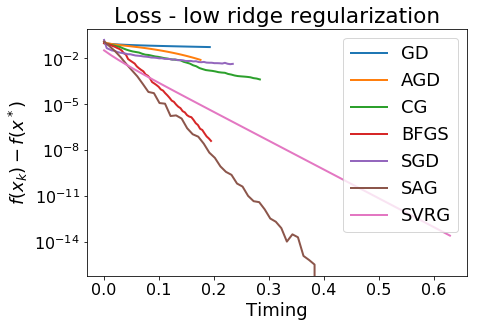

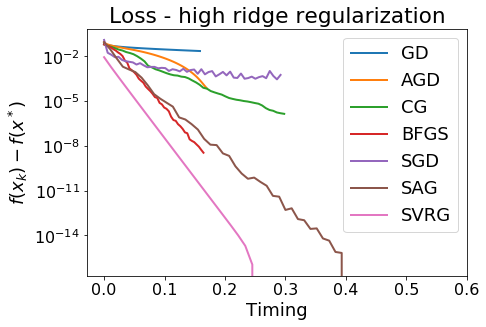

In [45]:
i = 0

for lbda in [1. / n, 1. / n ** (0.5)]:
    monitors, solvers = plot_all()
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, i+1)
    plot_time(monitors, solvers, title_sup="- %s ridge regularization" % title[i])
    i += 1

For the logistic regression, the ridge regularization (``lbda`` parameter) has **no effect on the accuracy** of all methods (Batch and Stochastic). However, the **speed of convergence** is impacted by this parameter:

\- All methods except BFGS and CG computes quickly when the regularization is low without a changement in the accuracy.

\- CG and BFGS are less accurate with low ridge regularization but the speed of convergence does not change.


- Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.

### Correlation with linear regression

Optimization terminated successfully.
         Current function value: 0.522266
         Iterations: 17
         Function evaluations: 24
         Gradient evaluations: 24
         Current function value: 0.530760
         Iterations: 26
         Function evaluations: 120
         Gradient evaluations: 108
         Current function value: 0.524047
         Iterations: 40
         Function evaluations: 71
         Gradient evaluations: 70
         Current function value: 0.533743
         Iterations: 50
         Function evaluations: 82
         Gradient evaluations: 82


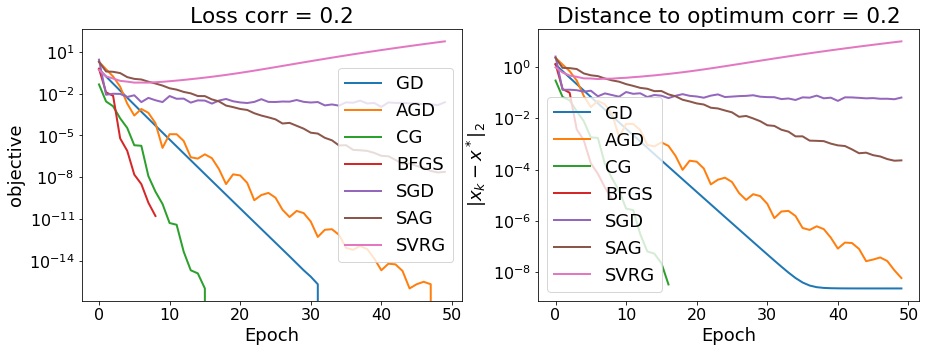

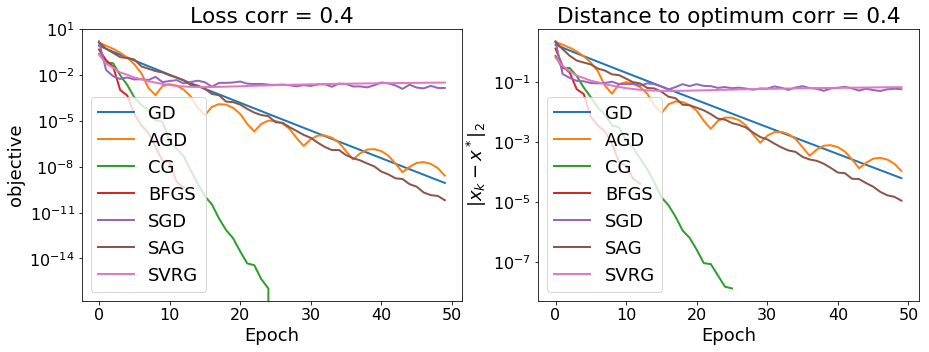

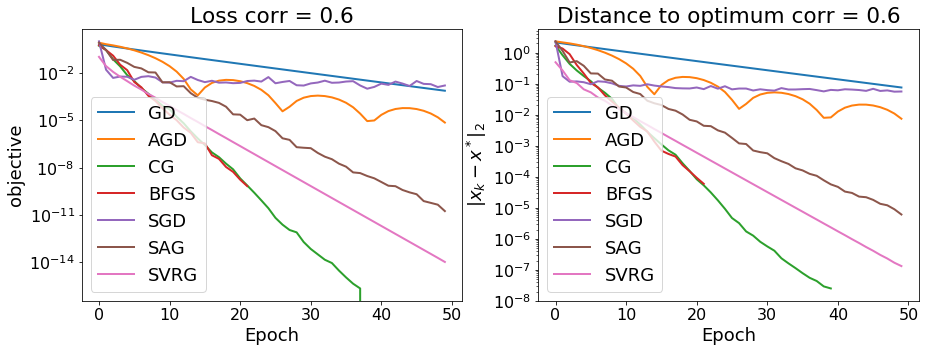

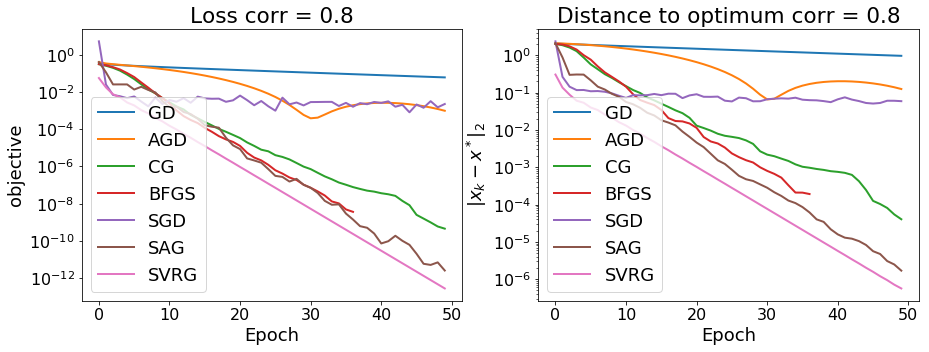

In [46]:
lbda = 1. / n ** (0.5)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg

for i in [0.2, 0.4, 0.6, 0.8]:
    A, b = simu_linreg(x_model_truth, n, std=1., corr=i)
    monitors, solvers = plot_all()
    plot_epochs(monitors, solvers, title_sup="corr = %s" % i)

         Current function value: 0.523347
         Iterations: 15
         Function evaluations: 21
         Gradient evaluations: 20
         Current function value: 0.521273
         Iterations: 28
         Function evaluations: 42
         Gradient evaluations: 41
         Current function value: 0.519360
         Iterations: 41
         Function evaluations: 127
         Gradient evaluations: 115
         Current function value: 0.518197
         Iterations: 50
         Function evaluations: 77
         Gradient evaluations: 77


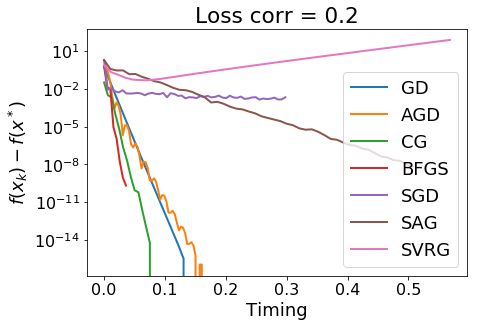

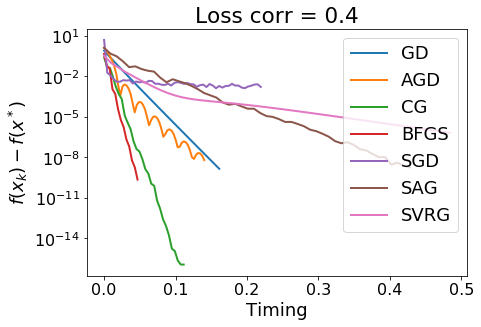

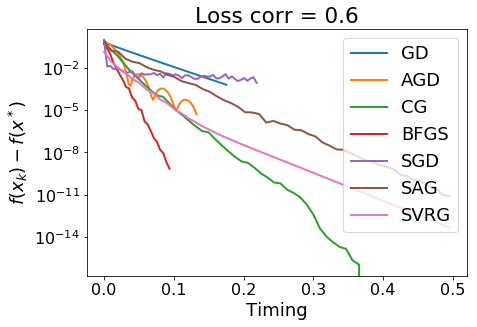

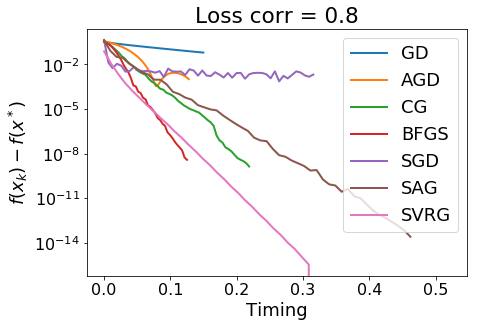

In [47]:
for i in [0.2, 0.4, 0.6, 0.8]:
    A, b = simu_linreg(x_model_truth, n, std=1., corr=i)
    monitors, solvers = plot_all()
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, int(i*5))
    plot_time(monitors, solvers, title_sup="corr = %s" % i)

For the linear regression and $\lambda = \frac{1}{\sqrt{n}}$ , when the correlation increases, **GD and AGD** are the most affected in a negative way.

Indeed, with low correlation (=0.2), they have better performance than stochastic methods but they become slower and slower with an increasing loss and distance to optimum for high correlation. When the correlation is high (=0.8), they are less accurate than the stochastic methods.

We observe the same effect on **CG and BFGS** algorithms. The increasing of loss and distance to optimum are not as big as GD and AGD but they become less accurate than SAG and SVRG.

On the contrary, with the increasing of the correlation, the **SVRG and SAG** algorithm become more accurate. Specially for the SVRG algorithm, for a correlation of 0.8, we have the smallest distance to optimum and loss. The speed of convergence is also affected. 

We observe the same effect for the **SAG** but with a lower level of improvement.

The **SGD** is not affected by the level of correlation in the linear regression case.

**Thus, except SGD, in the linear regression case, the batch and stochastic methods are affected by the level of correlation. When the correlation is high, the stochastic methods become more accurate than the batch ones.**



### Correlation with logistic regression

Optimization terminated successfully.
         Current function value: 0.369802
         Iterations: 19
         Function evaluations: 50
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: 0.430915
         Iterations: 28
         Function evaluations: 63
         Gradient evaluations: 63
         Current function value: 0.490090
         Iterations: 39
         Function evaluations: 96
         Gradient evaluations: 95
         Current function value: 0.557916
         Iterations: 50
         Function evaluations: 86
         Gradient evaluations: 86


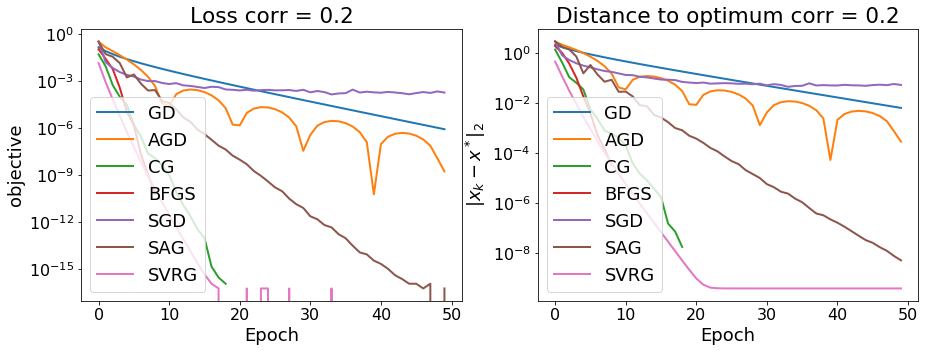

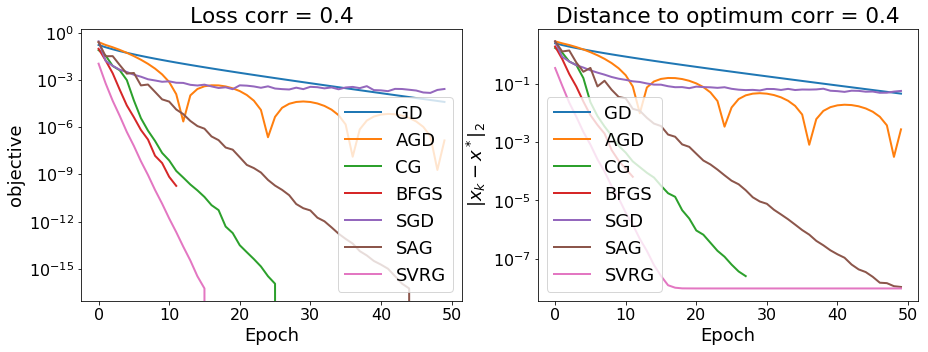

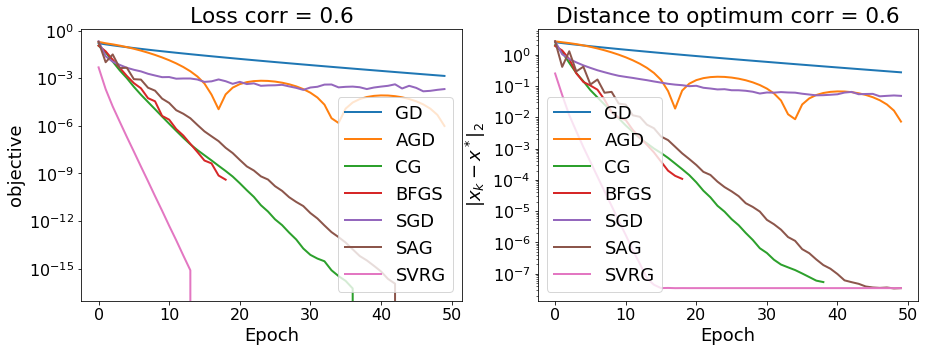

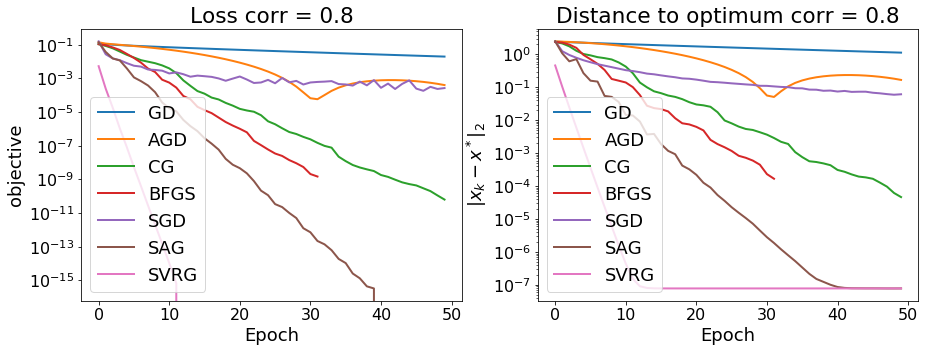

In [48]:
lbda = 1. / n ** (0.5)
loss = loss_logreg
grad = grad_logreg
grad_i = grad_i_logreg
lipschitz_constant = lipschitz_logreg

for i in [0.2, 0.4, 0.6, 0.8]:
    A, b = simu_logreg(x_model_truth, n, std=1., corr=i)
    monitors, solvers = plot_all()
    plot_epochs(monitors, solvers, title_sup="corr = %s" % i)

         Current function value: 0.380790
         Iterations: 20
         Function evaluations: 53
         Gradient evaluations: 52
         Current function value: 0.433937
         Iterations: 30
         Function evaluations: 141
         Gradient evaluations: 129
Optimization terminated successfully.
         Current function value: 0.495471
         Iterations: 39
         Function evaluations: 79
         Gradient evaluations: 79
         Current function value: 0.556393
         Iterations: 50
         Function evaluations: 89
         Gradient evaluations: 89


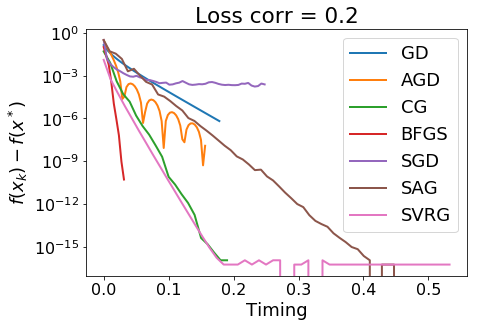

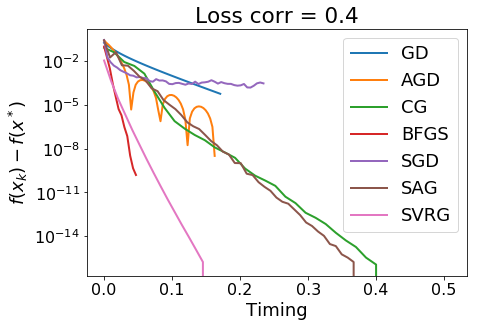

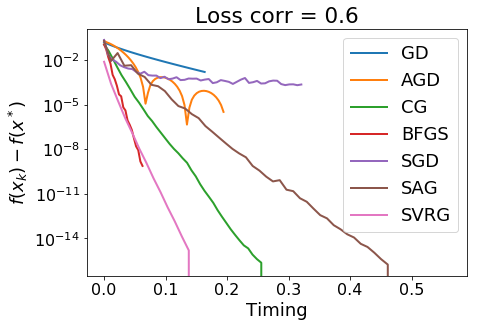

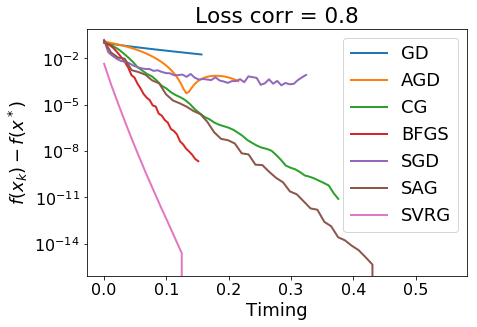

In [49]:
for i in [0.2, 0.4, 0.6, 0.8]:
    A, b = simu_logreg(x_model_truth, n, std=1., corr=i)
    monitors, solvers = plot_all()
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, int(i*5))
    plot_time(monitors, solvers, title_sup="corr = %s" % i)

For the logistic regression, when the correlation is small, **BFGS, SVRG and CG** have good performance.

When the correlation increases and $ \lambda = \frac{1}{\sqrt{n}} $, **CG and BFGS** become less performing and fluctuant.

**GD and AGD** are the most affected by high correlation because of the dependence of the features.

**Thus, the batch methods are very sensitive to the level of correlation. As the features correlation increases, the algorithms' speed of convergence decreases and the distance to optimum increases.**

On the contrary, stochastic methods are less sensitive to the correlation : when the correlation increases, **SGD** still has bad performance while **SVRG and SAG** have some improvement in terms of speed of convergence. 

The distance to optimum decreases as the correlation gets larger for **SAG**.But for **SGD and SVRG**, we don't have significant changes.



**Therefore, in the logistic regression case, the batch methods are very sensitive to the level of correlation but the stochastic methods are less sensitive.When the correlation is high, the batch methods become less accurate than the stochastic methods.**

- Conclude

**In conclusion**, we can say that the level of ridge regularization does not have a significant impact on the perfomance of the algorithms studied.

However, the level of correlation has a big impact in logistic and linear regression.

In case of high correlation, the stochastics methods will be preferred. SVRG is the most efficient but it will take more time. SAG could be chosen but it needs extra memory and has a slow speed of convergence.

In case of low correlation , the batch methods like CG or BFGS are better. In logistic regression, we can also use SVRG.